In [1]:
#--------------------------------------------------
#  LOAD PACKAGES
#--------------------------------------------------

require(plantecophys)
library(patchwork)
require(ggplot2)
library(drc)

Loading required package: plantecophys
Warning message:
"package 'patchwork' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: ggplot2
Warning message:
"package 'drc' was built under R version 3.6.3"Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:patchwork':

    area


'drc' has been loaded.

Please cite R and 'drc' if used for a publication,
for references type 'citation()' and 'citation('drc')'.


Attaching package: 'drc'

The following objects are masked from 'package:stats':

    gaussian, getInitial




 gmax PLA: [1] 252.46

 gmax O3 PLA: [1] 167.381


gmax,gmax_O3,T_min,T_max,T_opt,RH_max,RH_min,PAR,EXP
252.46,167.381,23,51,40,2.100302,-6.139909,0.007593573,TC1


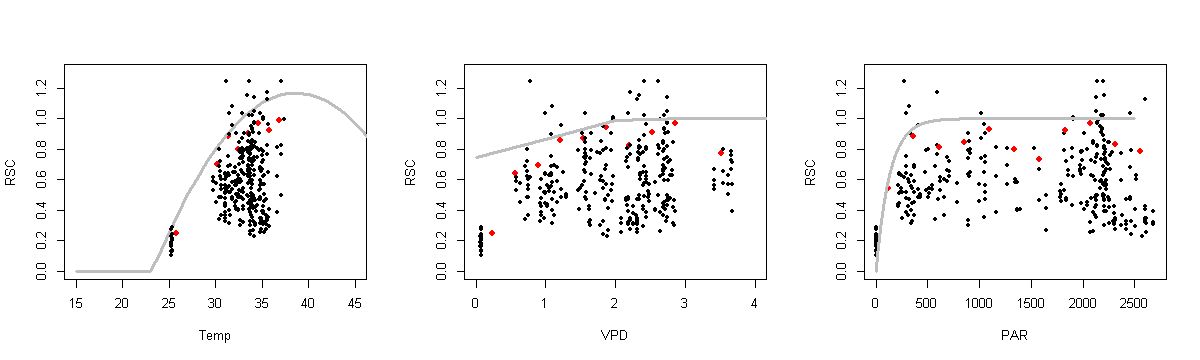

gmax,gmax_O3,T_min,T_max,T_opt,RH_max,RH_min,PAR,EXP
252.46,167.381,20,50,35,2.5,6,0.008,TC1


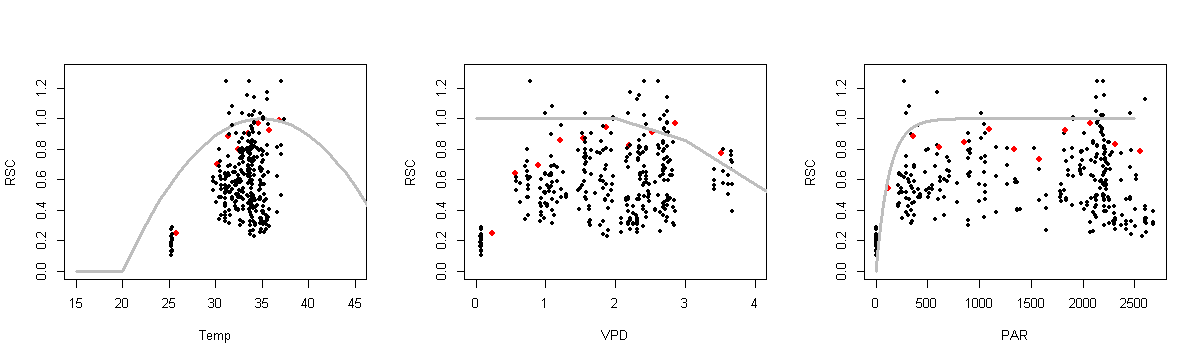

In [167]:
#--------------------------------------------------
#  LOAD FUNCTIONS
#--------------------------------------------------

setwd('C:/Users/fb428/OneDrive - University of Exeter/Documents/Tropoz/')
source('scripts/jarvis_functions.R')

f = 'TC1'

#--------------------------------------------------
#  LOAD DATA
#--------------------------------------------------

DATA <- read.csv(gsub(" ", "", paste( f,'/',f,'_Porometer.csv')))

#--------------------------------------------------
#  UNIFY COLNAMES
#--------------------------------------------------

if (!"VPD" %in% colnames(DATA)){
    VPD_kPa <- RHtoVPD(DATA$RH, DATA$AirTC_Avg, Pa = 101)
    DATA$VPD <- VPD_kPa
    }


DATA$datetime <- as.POSIXct(strptime(DATA$datetime, format="%d/%m/%Y %H:%M", tz="Australia/Brisbane"))

#--------------------------------------------------
#  CALCULATE GMAX
#--------------------------------------------------

abaxial <- RSC(DATA, 'Abaxial')
adaxial <- RSC(DATA, 'Adaxial')

gmax_ab <- gmax(abaxial)
gmax_ad <- gmax(adaxial)
gmax <- (gmax_ab + gmax_ad)/2
gmax_ozone <- gmax * 0.663

cat('\n gmax PLA: ')
print(gmax)

cat('\n gmax O3 PLA: ')
print(gmax_ozone)

Porometer <- rbind(abaxial, adaxial)


#--------------------------------------------------
#  DIVIDE INTO 11 GROUPS AND GET 90TH PERCENTILE
#--------------------------------------------------

Porometer <- na.omit(Porometer)

column_no <- which(colnames(Porometer) == 'RSC')

top_air <- top_90(Porometer$AirTC_Avg)
air_90 <- divide_10(Porometer$AirTC_Avg, column_no)
air_limits <- variable_center (Porometer$AirTC_Avg)

top_RH <- top_90(Porometer$VPD)
RH_90 <- divide_10(Porometer$VPD, column_no)
RH_limits <- variable_center (Porometer$VPD)

top_PAR <- top_90(Porometer$PAR_Den_Avg)
PAR_90 <- divide_10(Porometer$PAR_Den_Avg, column_no)
PAR_limits <- variable_center (Porometer$PAR_Den_Avg)


#--------------------------------------------------
#  FIT JARVIS PARAMETERS
#--------------------------------------------------

# FITTED BY MODEL

temp_coefs <- fit_poly(top_air)

T_min <- min(which(temp_function((1:50), temp_coefs) != 0))-1
T_opt <- which.max(temp_function((0:50), temp_coefs))
T_max <- max(which(temp_function((1:50), temp_coefs) != 0))+1

linear <- lm(RSC ~ VPD, data = top_RH)
RH_coefs <- coef(linear)

RH_min <- -RH_coefs[[1]]/RH_coefs[[2]]
RH_max <- (1-RH_coefs[[1]])/RH_coefs[[2]]

PAR_param <- 0.016
model <- drm(-RSC ~ PAR_Den_Avg, fct=EXD.3(fixed = c(-1,0, NA)),
            data = top_PAR[top_PAR$PAR_Den_Avg > 0,])
exp_param <- coef(model)[[1]]
PAR_param <- 1/exp_param

#-------------------------PLOT-----------------------

options(repr.plot.width = 10, repr.plot.height = 3)
par(mfrow=c(1,3))
plot(y = as.numeric(air_90), x = air_limits, col = 'red', pch = 16, xlim = c(15,45), ylim = c(0,1.3), ylab = 'RSC', xlab = 'Temp')
lines(x = (15:50),y = temp_function((15:50), temp_coefs) , lwd = 3, col = 'grey')
points(x = Porometer$AirTC_Avg, y = Porometer$RSC, pch = 20)

plot(y = as.numeric(RH_90), x = RH_limits, col = 'red', pch = 16, xlim = c(0,4), ylim = c(0,1.3), ylab = 'RSC', xlab = 'VPD')
points(x = Porometer$VPD, y = Porometer$RSC, pch = 20)
lines(x = (0:7), y = RH_function((0:7), RH_coefs), lwd = 3, col = 'grey')

plot(x = Porometer$PAR_Den_Avg, y = Porometer$RSC, pch = 20, xlim = c(0,2700), ylim = c(0,1.3), ylab = 'RSC', xlab = 'PAR', col = 'black')
points(y = as.numeric(PAR_90), x = PAR_limits, col = 'red', pch = 16)
lines(y = PAR_function((0:2500), PAR_param), x = (0:2500), lwd = 3, col = 'grey')

# SAVE COEFFICIENTS

jarvis_eq <- data.frame(gmax = c(gmax), gmax_O3 = c(gmax_ozone), T_min = c(T_min), T_max = c(T_max), T_opt = c(T_opt),
                           RH_max = c(RH_max), RH_min = c(RH_min), PAR = c(PAR_param), EXP = c(f))

jarvis_eq

# FITTED BY EYE

T_min <- 20
T_opt <- 35
T_max <- 50

test_data <- data.frame(RSC = c(0,1,0), AirTC_Avg = c(T_min,T_opt,T_max))
temp_coefs <- fit_poly(test_data)

RH_max <- 2.5
RH_min <- 6

linear <- lm(c(1,0) ~ c(RH_max,RH_min))
RH_coefs <- coef(linear)

PAR_param <- 0.008

# SAVE VALUES IN DATAFRAME

jarvis_byeye <- data.frame(gmax = c(gmax), gmax_O3 = c(gmax_ozone), T_min = c(T_min), T_max = c(T_max), T_opt = c(T_opt),
                           RH_max = c(RH_max), RH_min = c(RH_min), PAR = c(PAR_param), EXP = c(f))

jarvis_params <- merge(jarvis_byeye, jarvis_eq, all=TRUE)

write.csv( jarvis_params, gsub(" ", "", paste('outputs/script_output_',f,'/jarvis_',f,'.csv')), row.names=FALSE)

#-------------------------PLOT-----------------------

options(repr.plot.width = 10, repr.plot.height = 3)
par(mfrow=c(1,3))
plot(y = as.numeric(air_90), x = air_limits, col = 'red', pch = 16, xlim = c(15,45), ylim = c(0,1.3), ylab = 'RSC', xlab = 'Temp')
lines(x = (15:50),y = temp_function((15:50), temp_coefs) , lwd = 3, col = 'grey')
points(x = Porometer$AirTC_Avg, y = Porometer$RSC, pch = 20)

plot(y = as.numeric(RH_90), x = RH_limits, col = 'red', pch = 16, xlim = c(0,4), ylim = c(0,1.3), ylab = 'RSC', xlab = 'VPD')
points(x = Porometer$VPD, y = Porometer$RSC, pch = 20)
lines(x = (0:7), y = RH_function((0:7), RH_coefs), lwd = 3, col = 'grey')

plot(x = Porometer$PAR_Den_Avg, y = Porometer$RSC, pch = 20, xlim = c(0,2700), ylim = c(0,1.3), ylab = 'RSC', xlab = 'PAR', col = 'black')
points(y = as.numeric(PAR_90), x = PAR_limits, col = 'red', pch = 16)
lines(y = PAR_function((0:2500), PAR_param), x = (0:2500), lwd = 3, col = 'grey')

jarvis_byeye

In [168]:
a <- ggplot()+
geom_point(data = Porometer, aes(x = VPD, y = RSC, shape = as.factor(Position), colour = as.factor(Cham_ID)))+
  theme_bw()+
  xlab(expression(paste("VPD")))+
  ylab('Relative conductance')+
  theme(
    axis.text=element_text(size=15,colour="black"),
    line=element_line(colour="black"),
    axis.title=element_text(size=15),
    
    legend.position='none')

b <- ggplot()+
geom_point(data = Porometer, aes(x = PAR_Den_Avg, y = RSC, shape = as.factor(Position), colour = as.factor(Cham_ID)))+
  theme_bw()+
  xlab(expression(paste("PAR")))+
  ylab(expression(paste("Relative conductance", sep="")))+
  theme(
    axis.text=element_text(size=15,colour="black"),
    line=element_line(colour="black"),
    axis.title=element_text(size=15),
    
    )

c <- ggplot()+
geom_point(data = Porometer, aes(x = AirTC_Avg, y = RSC, shape = as.factor(Position), colour = as.factor(Cham_ID)))+
  theme_bw()+
  xlab(expression(paste("Air T")))+
  ylab(expression(paste("Relative conductance", sep="")))+
  theme(
    axis.text=element_text(size=15,colour="black"),
    line=element_line(colour="black"),
    axis.title=element_text(size=15),
      legend.position='none'
    )

# save and display plot

png(gsub(" ", "", paste('outputs/script_output_',f,'/RSC_', f, '.png')), width =  40, height = 20, units='cm', res = 330)

options(repr.plot.width=15, repr.plot.height=7)

a + c + b +
  plot_layout(widths = unit(10, 'cm'), heights = unit(10, 'cm'))

dev.off()

png 
  2


Call:
lm(formula = model ~ measured, data = RSC_ab)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.60791 -0.08320  0.03568  0.15404  0.41381 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.40750    0.04448    9.16   <2e-16 ***
measured     0.70604    0.06654   10.61   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2198 on 213 degrees of freedom
Multiple R-squared:  0.3458,	Adjusted R-squared:  0.3427 
F-statistic: 112.6 on 1 and 213 DF,  p-value: < 2.2e-16


png 
  2

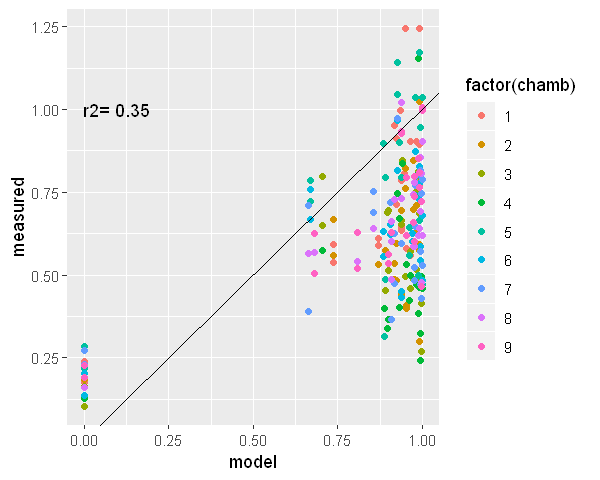

In [169]:
#--------------------------------------------------
#  TEST JARVIS PARAMETERS
#--------------------------------------------------

# predict conductance using funtions generated

Conductance_ab = temp_function(abaxial$AirTC_Avg, temp_coefs) * 
        RH_function(abaxial$VPD, RH_coefs) *
        PAR_function(abaxial$PAR_Den_Avg, PAR_param)

Conductance_ad = temp_function(adaxial$AirTC_Avg, temp_coefs) * 
        RH_function(adaxial$VPD, RH_coefs) *
        PAR_function(adaxial$PAR_Den_Avg, PAR_param)

#make dataframe of modelled and measured

modelled_conductance_ab <- data.frame(model = Conductance_ab, measured = abaxial$RSC, chamb = abaxial$Cham_ID, datetime = abaxial$datetime)
modelled_conductance_ad <- data.frame(model = Conductance_ad, measured = adaxial$RSC, chamb = adaxial$Cham_ID, datetime = adaxial$datetime)

# add day

RSC_ab <- add_day(modelled_conductance_ab)
RSC_ad <- add_day(modelled_conductance_ad)

r.squared <- lm(model ~ measured, data = RSC_ab)
summary(r.squared)


# save and display plot
options(repr.plot.width = 5, repr.plot.height = 4)
r <- ggplot()+
geom_point(data = RSC_ab, aes(x = model, y = measured, colour = factor(chamb)))+
geom_abline(aes(intercept = 0, slope = 1))+
annotate('text', x = 0.1, y = 1, label = paste('r2=', round(summary(r.squared)$r.squared, 2)))


png(gsub(" ", "", paste('outputs/script_output_',f,'/Jarvis_correlation_', f, '.png')), width =  15, height = 10, units='cm', res = 330)

r

dev.off()
r

png 
  2

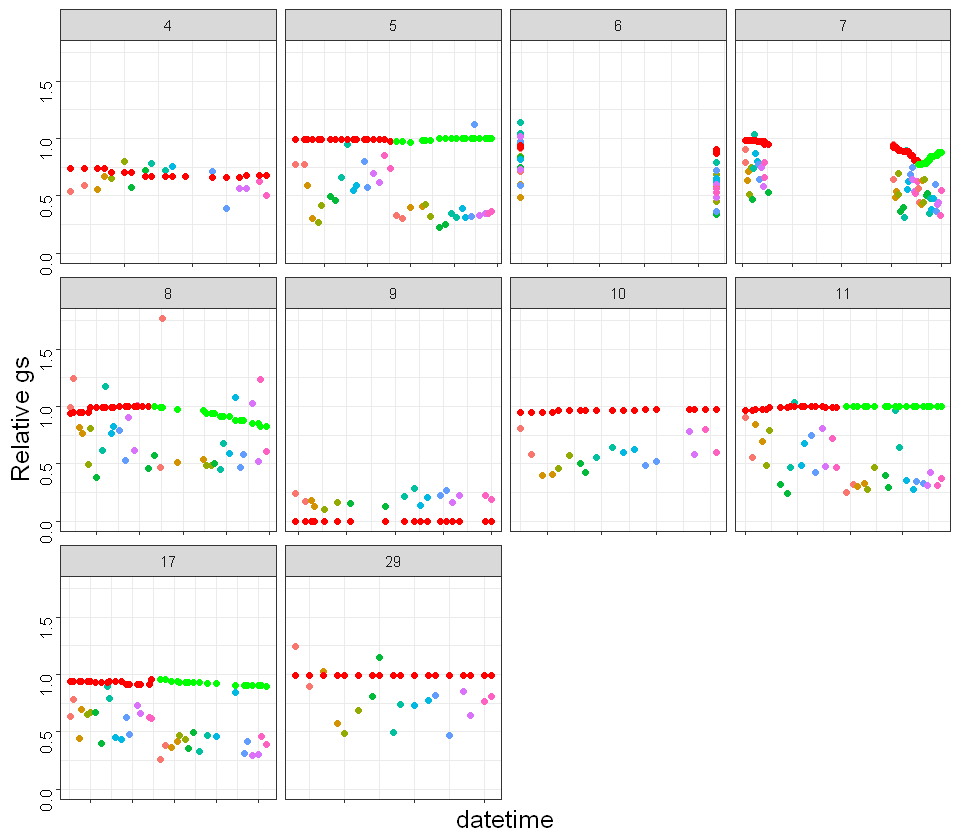

In [170]:
options(repr.plot.width = 8, repr.plot.height = 7)

a <- ggplot(data = RSC_ab)+
geom_point( aes(x = datetime, y = measured, colour = factor(chamb)))+
geom_point(data = RSC_ab, aes(x = datetime, y = model), color = 'red')+
geom_point(data = RSC_ad, aes(x = datetime, y = measured, colour = factor(chamb)))+
geom_point(data = RSC_ad, aes(x = datetime, y = model), color = 'green')+
facet_wrap(vars(as.numeric(Day)), scales = 'free_x')+
theme_bw()+
  #xlab(expression(paste("PAR")))+
  ylab('Relative gs')+
  theme(
    axis.text.x = element_blank(),
    axis.text=element_text(size=10,colour="black", angle = 90),
    line=element_line(colour="black"),
    axis.title=element_text(size=15),
    legend.position='none'
    )

# save and display plot

png(gsub(" ", "", paste('outputs/script_output_',f,'/Jarvis_preds_', f, '.png')), width =  25, height = 20, units='cm', res = 330)

a

dev.off()

a



png 
  2

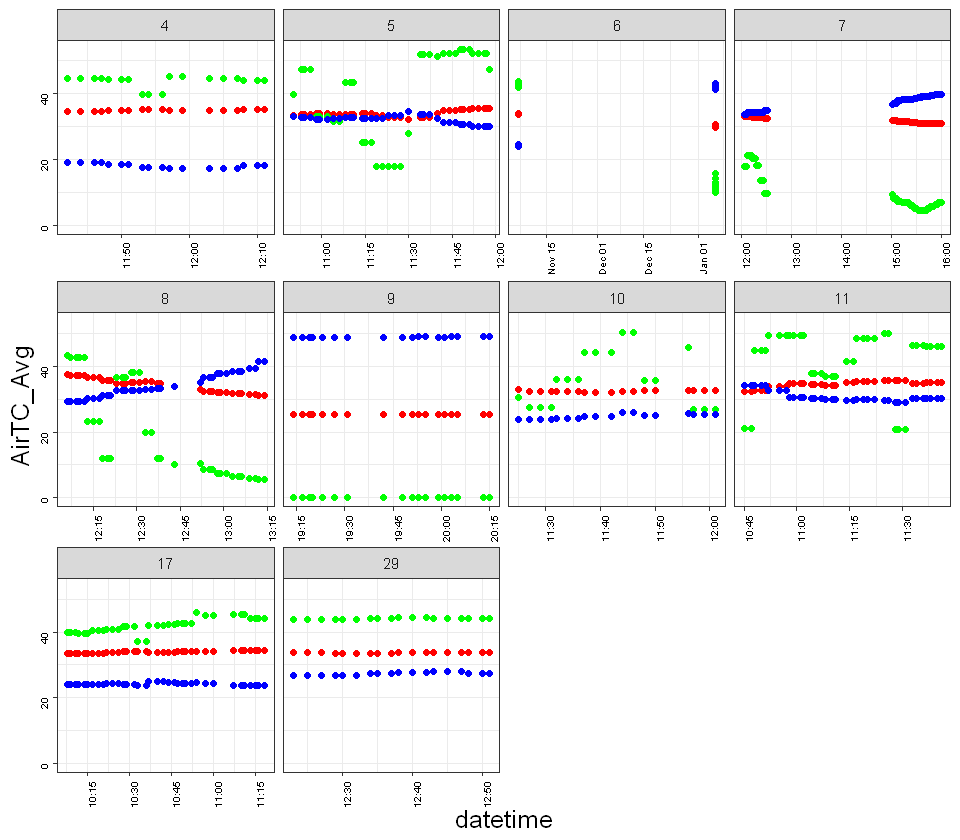

In [171]:
#Plot met conditions as comparison
Porometer_day <- add_day(Porometer)
b <- ggplot(data = Porometer_day)+
geom_point( aes(x = datetime, y = AirTC_Avg), color = 'red')+
geom_point( aes(x = datetime, y = PAR_Den_Avg/50), colour = 'green')+
geom_point( aes(x = datetime, y = RH/2), colour = 'blue')+
#geom_point(data = modelled_conductance, aes(x = datetime, y = Conductance), color = 'red')+
facet_wrap(vars(as.numeric(Day)), scales = 'free_x')+
theme_bw()+
  #xlab(expression(paste("PAR")))+
  #ylab(expression(paste("gs. (mmol ",m^-2, s^-1,")", sep="")))+
  theme(
#axis.text.x = element_blank(),
    axis.text=element_text(size=6,colour="black", angle = 90),
    line=element_line(colour="black"),
    axis.title=element_text(size=15),
    legend.position='none'
    )

# save and display plot

png(gsub(" ", "", paste('outputs/script_output_',f,'/Jarvis_met_', f, '.png')), width =  25, height = 20, units='cm', res = 330)

b

dev.off()

b